In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
import functools
import seaborn


sys.path.append("../functions")

from Utility import *

%matplotlib inline

In [2]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [3]:
trials_length = np.arange(10,400,5)
trials_length.shape[0]

78

In [4]:
from Forward import forward_fitting, simulate_agent
from Backward import backward_fitting

def calc_metrl(n_trials, subj):
    n_fitting = 100
    params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
    inpt_d = get_task_info(lv_induction_data, subj)
    for k,v in inpt_d.items():
        inpt_d[k] = v[:n_trials]
    inpt_d["n_fitting"] = n_fitting
    inpt_d["params_ranges"] = params_ranges
    
    mrls = []
    
    forward_params,_,_ = forward_fitting(inpt_d)

    backward_params,_,_ = backward_fitting(inpt_d)
    trials_info = get_subject_task(lv_induction_data, subj)[:n_trials]
    n_simulation = 100
    for i in range(n_simulation):
        resps, rewards, acc, confs, Q_list = simulate_agent(forward_params, trials_info)
        forward_perf = np.mean(acc)
        resps, rewards, acc, confs, Q_list = simulate_agent(backward_params, trials_info)
        backward_perf = np.mean(acc)
        mrls.append(backward_perf/forward_perf)
    return np.mean(mrls)

In [5]:
calc_metrl(400, subj = subjects[10] )

0.9228646722931987

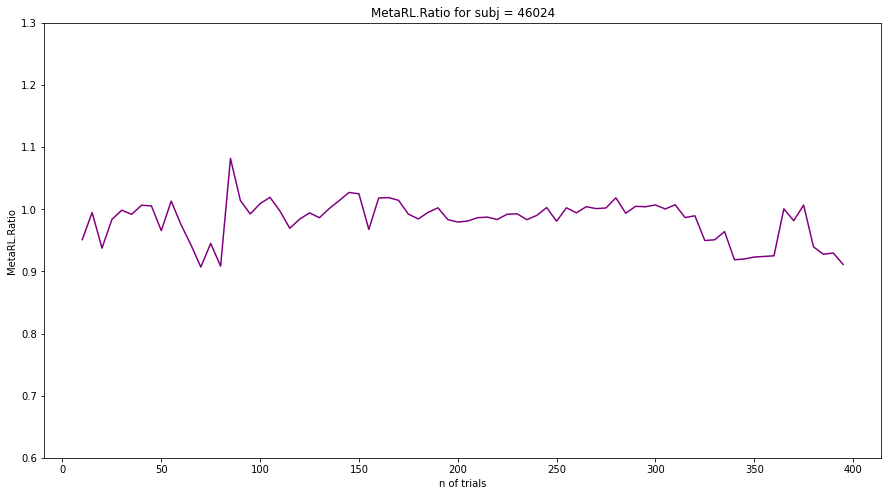

In [6]:
subj = subjects[10]
n_threads = 120
p_func = functools.partial(calc_metrl, subj = subj)
with Pool(n_threads) as p:
    result = np.array(p.map(p_func, trials_length))

plt.figure(figsize = (15,8))
plt.plot(trials_length, result, c = "purple")
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for subj = {}".format(subj))
plt.ylim([.6, 1.3])

plt.show()

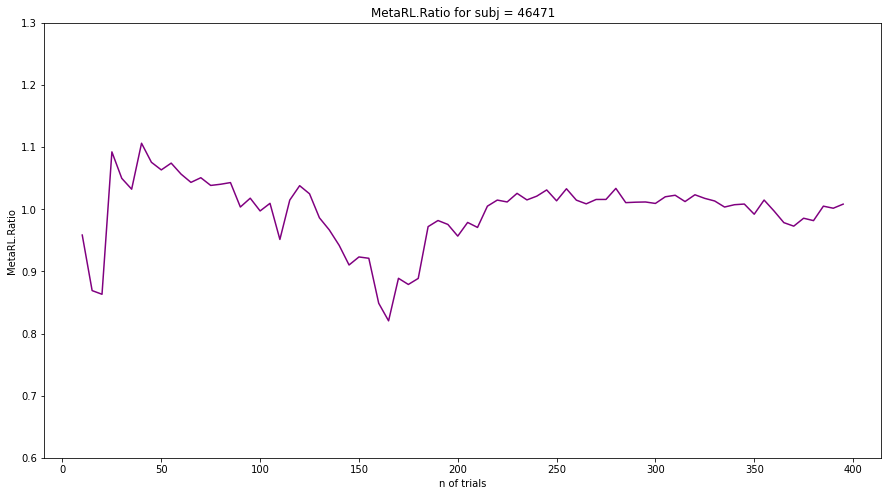

In [7]:
subj = subjects[23]
n_threads = 120
p_func = functools.partial(calc_metrl, subj = subj)
with Pool(n_threads) as p:
    result = np.array(p.map(p_func, trials_length))

plt.figure(figsize = (15,8))
plt.plot(trials_length, result, c = "purple")
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for subj = {}".format(subj))
plt.ylim([.6, 1.3])

plt.show()

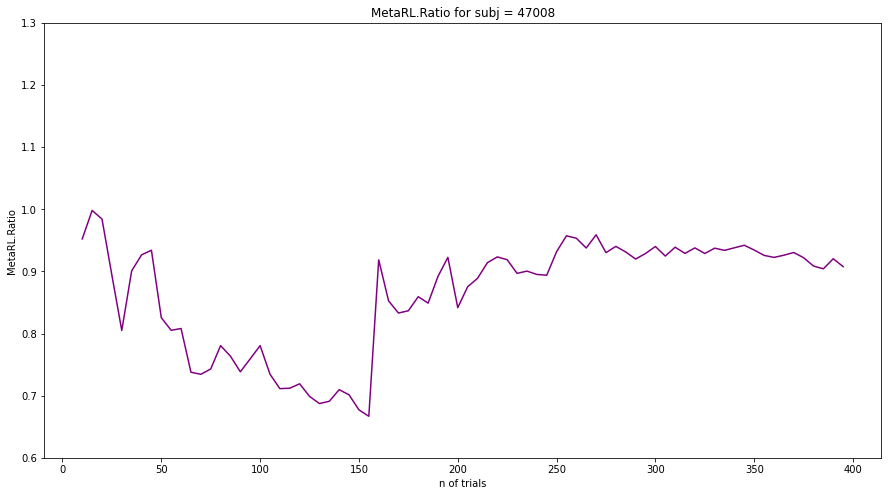

In [8]:
subj = subjects[44]
n_threads = 120
p_func = functools.partial(calc_metrl, subj = subj)
with Pool(n_threads) as p:
    result = np.array(p.map(p_func, trials_length))

plt.figure(figsize = (15,8))
plt.plot(trials_length, result, c = "purple")
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for subj = {}".format(subj))
plt.ylim([.6, 1.3])

plt.show()

In [ ]:
subj = subjects[32]
n_threads = 120
p_func = functools.partial(calc_metrl, subj = subj)
with Pool(n_threads) as p:
    result = np.array(p.map(p_func, trials_length))

plt.figure(figsize = (15,8))
plt.plot(trials_length, result, c = "purple")
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for subj = {}".format(subj))
plt.ylim([.6, 1.3])
plt.show()

In [9]:
res = []
for subj in subjects:
    p_func = functools.partial(calc_metrl, subj = subj)
    with Pool(n_threads) as p:
        result = np.array(p.map(p_func, trials_length))
    res.append(result)

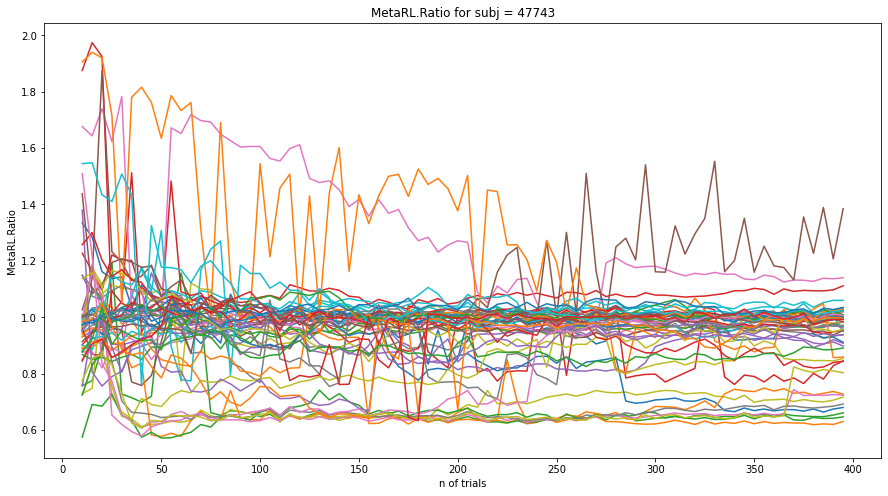

In [10]:
plt.figure(figsize = (15,8))

for r in res:
    plt.plot(trials_length, r)
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for subj = {}".format(subj))
plt.show()

In [11]:
residuals = []
subjects = []
trials = []
for i, r in enumerate(res):
    residuals.extend(r-r[-1])
    subjects.extend(len(r)*[i])
    trials.extend(trials_length)


In [12]:
df = pd.DataFrame(zip(subjects, trials, residuals), columns= ["sub", "trials", "residuals"])
df

,sub,trials,residuals
0,0,10,-0.036708
1,0,15,-0.007018
2,0,20,-0.037849
3,0,25,-0.000575
4,0,30,0.004200
...,...,...,...
4207,53,375,0.019474
4208,53,380,-0.017625
4209,53,385,-0.004253
4210,53,390,-0.000429


In [22]:
df.to_csv("../results/n_trials_mrl.csv")

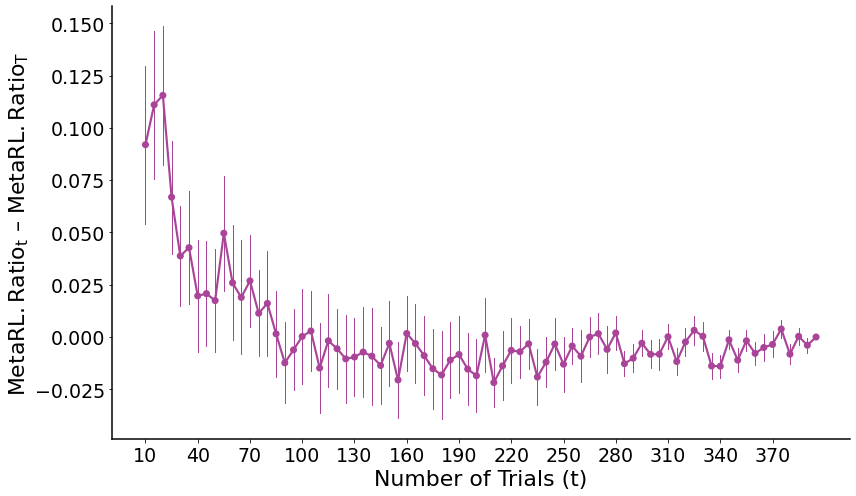

In [9]:
plt.figure(figsize = (12,7))
df = pd.read_csv("../results/n_trials_mrl.csv")
seaborn.pointplot(
    data=df,
    x="trials",
    y="residuals",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    color="#AA4499"
)
ax = plt.gca()

plt.ylabel(r"$MetaRL.Ratio_t $" +" – "  +r"$ MetaRL.Ratio_T$", fontsize=22)
plt.xlabel("Number of Trials (t)", fontsize=22)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.rcParams.update({'mathtext.default':  'regular' })


plt.locator_params(axis='x', nbins = 15)

plt.tight_layout()
plt.savefig("../figs/Ntrials.png", dpi=400, bbox_inches = "tight")


plt.show()

In [ ]:
def calc_metrl_from_params(n_trials, forward_params, backward_params):
    mrls = []
    trials_info = get_subject_task(lv_induction_data, subj)[:n_trials]
    for n in range(30):
        resps, rewards, acc, confs, Q_list = simulate_agent(forward_params, trials_info)
        forward_perf = np.mean(acc)
        resps, rewards, acc, confs, Q_list = simulate_agent(backward_params, trials_info)
        backward_perf = np.mean(acc)
        mrls.append(backward_perf/forward_perf)
    return np.mean(mrls)

In [ ]:
alpha_list = [.3, .7]
beta_list = [10, 30]
params_list = []
parametric_res = []
for for_alpha in alpha_list:
    for for_beta in beta_list:
        for back_alpha in alpha_list:
            for back_beta in beta_list:
                forward_params = [for_alpha, for_beta, .5, 1]
                backward_params = [back_alpha, back_beta, .5, 1]
                p_func = functools.partial(calc_metrl_from_params, forward_params = forward_params, backward_params = backward_params)
                with Pool(n_threads) as p:
                    result = np.array(p.map(p_func, trials_length))
                parametric_res.append(result)
                params_list.append((forward_params, backward_params))

In [ ]:
f, axs = plt.subplots(16, 1, layout='constrained', figsize=(15, 80))
cnt = 0
for param, result in zip(params_list, parametric_res):
    forward_params, backward_params = param
    axs[cnt].plot(trials_length, result, c = "purple")
    axs[cnt].set_xlabel("n of trials")
    axs[cnt].set_ylabel("MetaRL.Ratio")
    axs[cnt].set_title("MetaRL.Ratio for forward_params = {} and backward_params = {}".format(forward_params[:2], backward_params[:2]) )
    cnt +=1 
    

In [ ]:
forward_params = [.3, 10, .5, 1]
backward_params = [.7, 10, .5, 1]
p_func = functools.partial(calc_metrl_from_params, forward_params = forward_params, backward_params = backward_params)
with Pool(n_threads) as p:
    result = np.array(p.map(p_func, trials_length))

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(trials_length, result, c = "purple")
plt.xlabel("n of trials")
plt.ylabel("MetaRL.Ratio")
plt.title("MetaRL.Ratio for forward_params = {} and backward_params = {}".format(forward_params[:2], backward_params[:2]) )

plt.show()